## 泰坦尼克号幸存者预测

In [1]:
# 导入相关包
import pandas as pd
from keras import layers
from keras import Sequential
from keras.layers import LeakyReLU

from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 加载训练表和测试表
df_titanic = pd.read_csv('./train.csv')
df_test = pd.read_csv("./test.csv")

In [3]:
# 查看数据
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# 查看所有字段信息
df_titanic.info()
print("_ "*50)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtyp

In [5]:
# 查看数据概要
df_titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# 查看非数值型特征概要
df_titanic.describe(include=["O"])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Homer, Mr. Harry (""Mr E Haven"")",male,CA. 2343,G6,S
freq,1,577,7,4,644


In [7]:
# 查看每个字段分别有多少个空值
df_titanic.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

<AxesSubplot:>

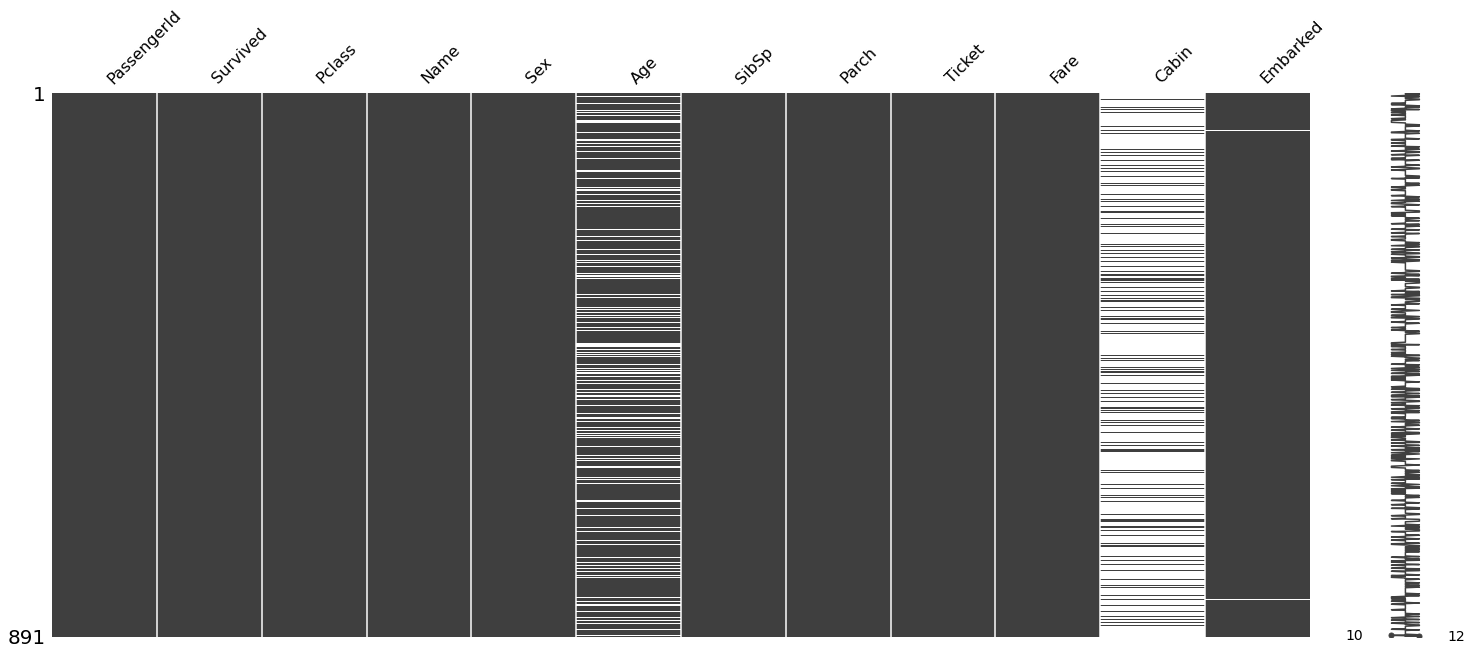

In [8]:
# 图形化查看空值分布
import missingno as msno
msno.matrix(df_titanic)


#### 数据表简要分析

- 关于空值
    - Cabin列太多空值了，要是全部按行删除那基本上不用分析了，所以Cabin列可以直接忽略(删除)。
    - Age列有177个空值，不算很多，我们用均值标准差的差到两者之间的和作随机数填补空值。
    - Embarked列有2个空值，这是一个类型列，而且空值数量不多，所以我们用最常出现的类型填补这两个空值。
- 关于类型
    - Ticket列一共有891行，但只有681个唯一值，那么可以说明最起码有105个人(最起码两人共用一个船票信息?)不是独立乘船的。
    - 男女分别占比64%、36%（577名男性和314名女性）
    - 估计PassengerId和Name和Ticket字段对目标(Survived)没什么贡献。

### 基本统计

In [9]:
df_titanic[["Survived", "Pclass"]].groupby("Pclass", as_index=False).mean().sort_values("Pclass", ascending=True)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [10]:
df_titanic[["Survived", "Sex"]].groupby("Sex", as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [11]:
df_titanic[["Survived", "Embarked"]].groupby("Embarked", as_index=False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


In [12]:
df_titanic[["Survived", "Parch"]].groupby("Parch", as_index=False).mean().sort_values("Survived", ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


In [13]:
df_titanic[["Survived", "SibSp"]].groupby("SibSp", as_index=False).mean().sort_values("Survived", ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


#### 基本统计解析和猜测
- 船舱等级为1的乘客幸存率最高，达到了64%，所以Pclass与幸存率有关？
- 女性比男性幸存率高好几倍，这是电视中的小孩妇人优先？
- 登船码头(Embarked)为C的幸存率最高，但是从S登船的旅客最多，或许不同登船码头决定了逃生的便捷性？比如C登船的旅客离救生艇更近？
- 有3个直系亲属的生存率最高，有1个兄弟姐妹的生存率也最高，单身寡佬只有34%左右生存率，或许家人与逃生欲望有关系？


### 数据图形化

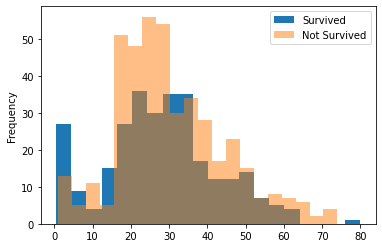

In [14]:
df_titanic[df_titanic["Survived"] == 1]["Age"].plot(kind="hist",label="Survived", bins=20, xlabel="AAA")
df_titanic[df_titanic["Survived"] == 0]["Age"].plot(kind="hist", alpha=0.5, label="Not Survived", bins=20)
plt.legend()

- 年龄小(小于4岁左右?)和最大年龄段的存活率比其他人要高，尊老爱幼实锤了。

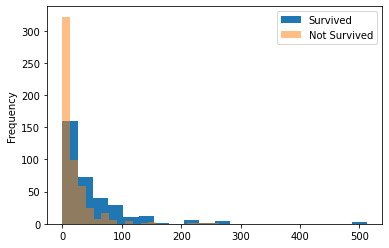

In [15]:
df_titanic[df_titanic['Survived'] == 1]["Fare"].plot(kind='hist', label="Survived", bins=20)
df_titanic[df_titanic['Survived'] == 0]["Fare"].plot(kind='hist',label="Not Survived", alpha=0.5, bins=20)
plt.legend()

- 存活率跟票价没啥关系

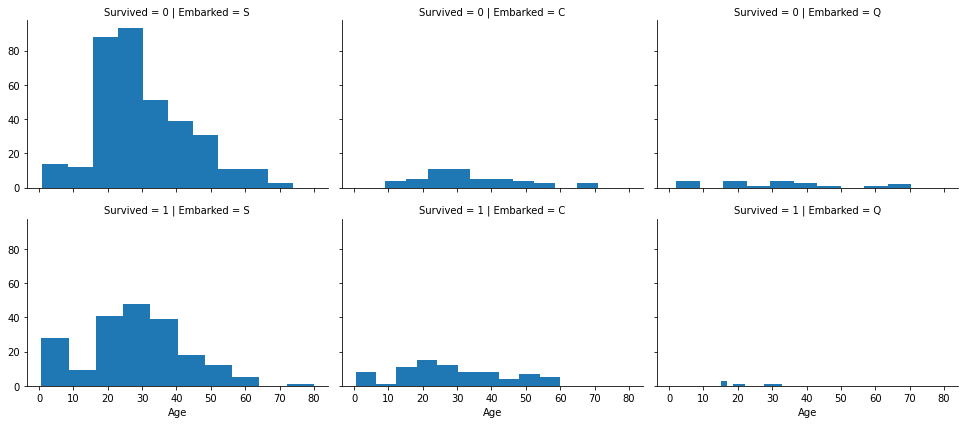

In [16]:
gird = sns.FacetGrid(df_titanic, col='Embarked', row='Survived', aspect=1.5)
gird.map(plt.hist, "Age")

- 在码头S登船的人最多，所以样本分布最广，在Q码头登船的人最少，样本分布最低。

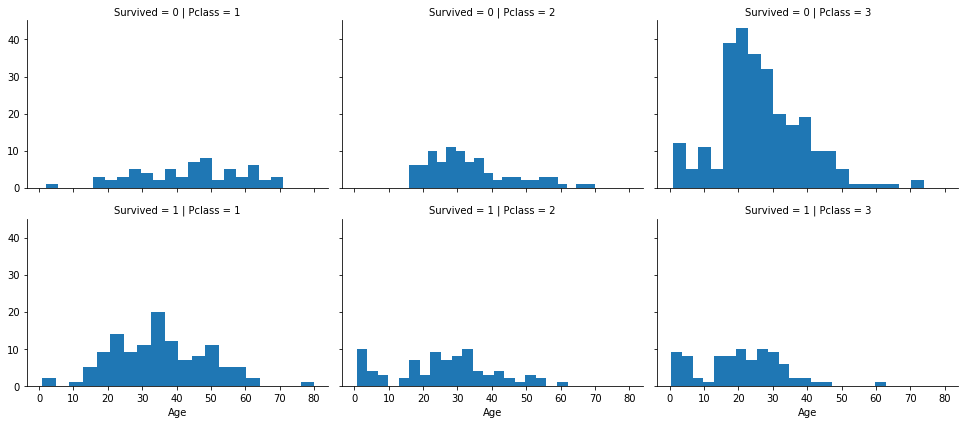

In [17]:
pclass_gird = sns.FacetGrid(df_titanic, col='Pclass', row='Survived', aspect=1.5)
pclass_gird.map(plt.hist, "Age", bins=20)
pclass_gird.add_legend();

- 在第三船舱的年轻人死亡率最高，第一船舱青年人生存率最高，可以认定所在船舱对生存率有关系。

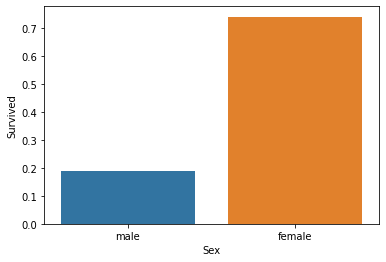

In [18]:
sns.barplot(data=df_titanic,x="Sex", y="Survived",ci=None);

- 女性比男性生存率高很多。

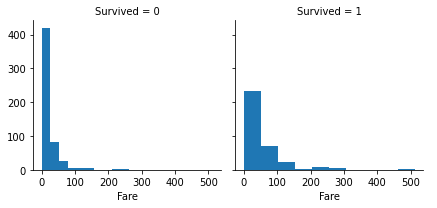

In [19]:
fare_grid = sns.FacetGrid(df_titanic, col="Survived")
fare_grid.map(plt.hist, "Fare")
fare_grid.add_legend()

- 多数人买的都是低价票，而且没啥存活率关系。

### 代码部分

In [20]:
# 将‘类型’特征转化为数值，便于网络读取
def trans_category(dataset, category, *, mapper={}, inplace=False):
    # 断言有这么个字段
    assert category in dataset.columns, f"Dataset's column: [{dataset.columns}] exclude [{category}]"
    # 允许自定义数值
    if any(mapper):
        dataset[category] = dataset[category].map(mapper)
    else:
        # factorize方法返回(对应数值，类型)，用唯一数值对应唯一类型，将类型转换成数值，并且数值不取0。
        index, fac = dataset[category].factorize()
        index_unqiue = np.unique(index) + 1
        fac_unique = np.unique(fac)
        fac_mapper = dict(zip(fac_unique, index_unqiue))
        if inplace:
            dataset[category] = dataset[category].map(fac_mapper)
        else:
            return dataset[category].map(fac_mapper)

In [21]:
# 将离散类型转化为范围，例如将年龄转化为(0-10]，(10-20]等
def trans_continue(dataset, continue_feature, /, bins=5, *, inplace=False):
    # 断言字段在数据表中
    assert continue_feature in dataset.columns,  f"Dataset's column: [{dataset.columns}] exclude [{category}]"
    # 确定类型为离散值
    continue_dtype = dataset[continue_feature].dtype
    dtypes = [continue_dtype == int, continue_dtype==float]
    assert any(dtypes), f"Column [{continue_feature}] is not continue feature!"
    
    # 建立范围
    bound_feature = "".join([continue_feature, "Bound"])
    dataset[bound_feature] = pd.cut(dataset[continue_feature], bins=bins)
    
    fac, _ = dataset[bound_feature].factorize()
#     dataset[continue_feature] = fac
    if inplace:
        dataset[continue_feature] = fac + 1
    else:
        return fac

In [22]:
# 填充age字段的空值
def fill_age(dataset, *, inplace=False):
    _mean = dataset["Age"].mean()
    _std = dataset["Age"].std()
    _fill = np.random.randint(_mean - _std, _mean + _std, dataset["Age"].isna().sum())
    if inplace:
        dataset.loc[dataset["Age"].isna(), "Age"] = _fill
    else:
        return _fill

In [23]:
# 根据频率填充‘类型’特征的空值
def fill_by_freq(dataset, feature, *, inplace=False):
    assert feature in dataset.columns, f"Feature [{feature}] excluded in {dataset.columns}"
    mode = dataset[feature].mode()[0]
    if inplace:
        dataset[feature] = dataset[feature].fillna(mode)
    else:
        return mode

In [24]:
# 将所有名字根据Miss, Mrs, Dr等划分特征
def combine_name(dataset, *, inplace=False):
    dataset["Title"] = dataset.Name.str.extract("([A-Za-z]+)\.")
    syn_calls = {"Mlle":"Miss", "Mme":"Mrs", "Ms":"Miss"}
    dataset["Title"] = dataset.Title.replace(syn_calls)
    title_counts = dataset.Title.value_counts()
    # 所有出现频率小于40的值统一设置为指定值，默认Other
    uncommon = title_counts[title_counts<40].index
    if inplace:
        dataset["Title"] = dataset.Title.replace(uncommon,"Other")
    else: return uncommon

In [25]:
# 确定某位乘客是否单身，并且将结果写进IsAlone列
def make_isalone(dataset, *, inplace=False):
    columns = dataset.columns
    act = ["Parch" in columns, "SibSp" in columns]
    assert all(act), "Parch or SliSp exclued in columns"
    family_size = dataset["Parch"] + dataset["SibSp"] + 1
    family_size = family_size.map(lambda x:0 if x>1 else 1)
    if inplace:
        dataset["IsAlone"] = family_size
    else:
        return family_size

In [26]:
# 将集合合并
combine = [df_titanic, df_test]

In [27]:
# 对测试集和测试集应用所有相同变换
for dataset in combine:
    fill_by_freq(dataset, "Embarked", inplace=True)
    fill_age(dataset, inplace=True)
    
    combine_name(dataset,inplace=True)
    trans_category(dataset, "Title", inplace=True)
    trans_category(dataset, "Sex", inplace=True)
    trans_category(dataset, "Embarked", inplace=True)
    
    trans_continue(dataset, "Age", inplace=True)
    trans_continue(dataset, "Fare", inplace=True)
    
    make_isalone(dataset,inplace=True)

In [28]:
# 查看变换结果
df_titanic.info()
print(" _" * 40)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    object  
 4   Sex          891 non-null    int64   
 5   Age          891 non-null    int64   
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    int64   
 10  Cabin        204 non-null    object  
 11  Embarked     891 non-null    int64   
 12  Title        891 non-null    int64   
 13  AgeBound     891 non-null    category
 14  FareBound    891 non-null    category
 15  IsAlone      891 non-null    int64   
dtypes: category(2), int64(11), object(3)
memory usage: 100.1+ KB
 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

- 变换完毕以后，"PassengerId", "Cabin", "SibSp", "Parch", "Ticket", "Name", "AgeBound", "FareBound" 这些字段将不参与网络计算，由
变换完毕后的字段参与。

In [29]:
# 删除无用列
be_dropped_columns = ["PassengerId", "Cabin", "SibSp", "Parch", "Ticket", "Name", "AgeBound", "FareBound"]
df_train = df_titanic.drop(columns=be_dropped_columns, axis=1)

In [30]:
# 建立label和train set
y_train = df_train.pop("Survived")
x_train = df_train.to_numpy()

x_test = df_test.drop(be_dropped_columns, axis=1).to_numpy()

In [31]:
# 将所有值改为float32，方便Dense层计算
x_train, y_train = x_train.astype("float32"), y_train.astype("float32")
x_test = x_test.astype("float32")

In [32]:
# 统计互信息
mi = mutual_info_classif(x_train, y_train)

In [33]:
pd.Series(mi, index=df_train.columns).sort_values(ascending=False)[:3]

Title       0.168880
Sex         0.143315
Embarked    0.063676
dtype: float64

> 互信息能表达特征与目标之间的线性和非线形关系
- 可以看出Title字段与目标关联最大，性别其次。

### 模型部分

In [34]:
# 新建模型，采用2个隐藏层的架构
model = Sequential()
model.add(layers.Dense(128, input_shape=(x_train.shape[-1],)))
model.add(LeakyReLU(alpha=0.01))

model.add(layers.Dense(128))
model.add(LeakyReLU(alpha=0.01))

# model.add(layers.Dense(256))
# model.add(LeakyReLU(alpha=0.01))

model.add(layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [35]:
history = model.fit(x_train, y_train, epochs=400, validation_split=0.2, batch_size=128, verbose=0, shuffle=True)

In [36]:
hd = history.history
val_loss = hd["val_loss"]
loss = hd["loss"]

accuracy = hd["accuracy"]
val_accuracy = hd["val_accuracy"]

epochs = range(1, len(accuracy)+1)

print(f"Mean Val Accuracy: {np.mean(val_accuracy)}")
print(f"Mean Accuracy: {np.mean(accuracy)}")
print("= " * 20)
print(f"Mean Loss: {np.mean(loss)}")
print(f"Mean Val Loss: {np.mean(val_loss)}")

Mean Val Accuracy: 0.8413268135488033
Mean Accuracy: 0.8271910059452057
= = = = = = = = = = = = = = = = = = = = 
Mean Loss: 0.38032404765486716
Mean Val Loss: 0.3902588853985071


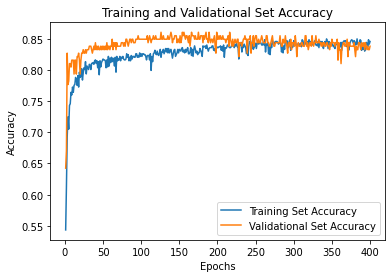

In [37]:
plt.plot(epochs, accuracy, label="Training Set Accuracy")
plt.plot(epochs, val_accuracy, label="Validational Set Accuracy")
plt.title("Training and Validational Set Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend()


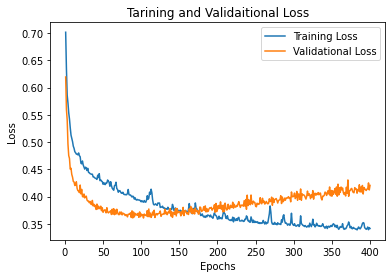

In [38]:
plt.clf()
plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validational Loss")
plt.title("Tarining and Validaitional Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()

#### 基准模型解析
基准模型采用了最简单的网络架构，结果在150轮开始过拟合，准度降低损失升高。

#### 采用K折交叉验证来保证模型得分的可靠性
由于训练数据较少，仅有819条，所以采用K折交叉验证可靠性会高一点。

In [39]:
# sklearn辅助
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

Text(0, 0.5, 'K Score')

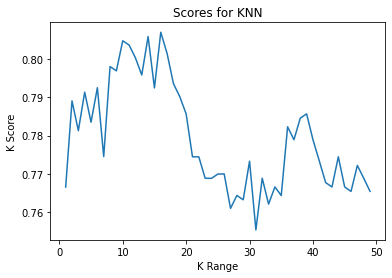

In [40]:
# 利用sklearn来计算哪个K值为最佳
k_range = range(1, 50)
k_scores = []
for i in k_range:
    knn = KNeighborsClassifier(n_neighbors=i)
    score = cross_val_score(knn, x_train, y_train, cv=10, scoring='accuracy')
    k_scores.append(score.mean())

plt.plot(k_range, k_scores)
plt.title("Scores for KNN")
plt.xlabel("K Range")
plt.ylabel("K Score")

In [41]:
# k值为上面计算出来的最佳值的下标+1
k = np.argmax(k_scores) + 1

In [42]:
# 进行K折验证
k_fold = KFold(n_splits=k, shuffle=True)
indicies = k_fold.split(x_train)
losses = []
accuracies = []
preds = []
models = []

val_losses = []
val_accuracies = []
for train_indicies, val_indicies in indicies:
    x_val, y_val = x_train[val_indicies], y_train[val_indicies]
    kx_train, ky_train = x_train[train_indicies], y_train[train_indicies]
    
    model = Sequential()
    model.add(layers.Dense(64, input_shape=(kx_train.shape[-1],)))
    model.add(LeakyReLU(alpha=0.01))
    model.add(layers.Dropout(0.5))
    
    
    model.add(layers.Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy",  optimizer="adam", metrics=["accuracy"])
    
    history = model.fit(kx_train, ky_train, epochs=300, batch_size=64, verbose=0)
    
    losses.append(np.mean(history.history['loss']))
    accuracies.append(np.mean(history.history['accuracy']))
    val_loss, val_accuracy = model.evaluate(x_val, y_val)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    preds.append(model.predict(x_test))
    models.append(model)

2/2 [==============================] - 0s 2ms/step - loss: 0.6195 - accuracy: 0.7273


2/2 [==============================] - 0s 2ms/step - loss: 0.4165 - accuracy: 0.8182


In [43]:
result_df = pd.DataFrame({"K": range(k), "Accuracy": accuracies,"Loss": losses, "Val_Accuracy": val_accuracies, "Val_Loss": val_losses})

In [44]:
melt_df = result_df.melt(id_vars="K", var_name="var_name", value_name="values")

In [45]:
melt_df.head()

,K,var_name,values
0,0,Accuracy,0.786475
1,1,Accuracy,0.791513
2,2,Accuracy,0.790128
3,3,Accuracy,0.788439
4,4,Accuracy,0.792048


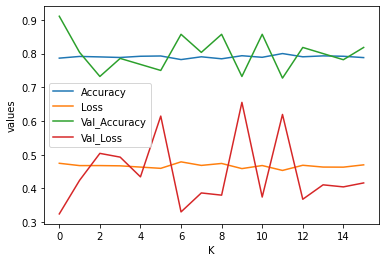

In [46]:
sns.lineplot(data=melt_df, x="K", y="values", hue='var_name')
plt.legend()

- 在数据量不足的情况下，得到的损失值波动较大，准确率还算可以。

In [59]:
print(f"Mean loss: {np.mean(losses)}")
print(f"Mean accuracy: {round(np.mean(accuracies) * 100, 2)}%")

print(f"Mean val loss: {np.mean(val_losses)}")
print(f"Mean val accuracy: {round(np.mean(val_accuracies) * 100, 2)}%")

Mean loss: 0.46676663847640154
Mean accuracy: 79.03%
Mean val loss: 0.44636147283017635
Mean val accuracy: 80.02%


- 平均验证准度为80%左右，损失在44%左右，与训练集的准度相差无几，可以认为没有过拟合。

In [49]:
# 自己实现的K-Fold验证

# k = 10
# each_volumn = len(x_train) // k
# losses = []
# accuracies = []
# preds = []
# models = []

# k_train = x_train.copy()
# k_label = y_train.copy()

# for i in range(0, k):
#     indicies = np.arange(len(k_train))
#     np.random.shuffle(indicies)
#     k_train = k_train[indicies]
#     k_label = k_label[indicies]
    
#     x_val = k_train[i * each_volumn: (i+1) * each_volumn]
#     y_val = k_label[i * each_volumn: (i+1) * each_volumn]
    
#     k_x_train = np.concatenate([
#         k_train[(i+1) * each_volumn:],
#         k_train[:i * each_volumn]
#     ])
    
#     k_y_train = np.concatenate([
#         k_label[(i+1) * each_volumn:],
#         k_label[:i * each_volumn]
#     ])

#     model = Sequential()
#     model.add(layers.Dense(128, input_shape=(k_x_train.shape[-1],)))
#     model.add(LeakyReLU(alpha=0.01))
    
    
#     model.add(layers.Dense(256))
#     model.add(LeakyReLU(alpha=0.01))
#     model.add(layers.Dropout(0.5))
    
#     model.add(layers.Dense(256))
#     model.add(LeakyReLU(alpha=0.01))
#     model.add(layers.Dropout(0.5))
    
#     model.add(layers.Dense(1, activation="sigmoid"))
#     model.compile(loss="binary_crossentropy",  optimizer="adam", metrics=["accuracy"])
    
#     history = model.fit(k_x_train, k_y_train, epochs=400, batch_size=128, verbose=0)
#     print(f"Acc avg: {np.mean(history.history['accuracy'])}")
#     print(f"Loss avg: {np.mean(history.history['loss'])}")
#     loss, accuracy = model.evaluate(x_val, y_val)
#     losses.append(loss)
#     accuracies.append(accuracy)
#     preds.append(model.predict(x_test))
#     models.append(model)
    
    
    

In [51]:
# 使用准确率最高的模型来对测试集进行预测
best_indice = np.argmax(accuracies)
best_model = models[best_indice]
dnn_predict = best_model.predict_classes(x_test)

/Users/chanzeebm/opt/miniconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [52]:
dnn_predict = dnn_predict.reshape((len(dnn_predict),))

### Sklearn机器学习模型评估

In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

In [54]:
# 决策树评估
dicision_tree = DecisionTreeClassifier()
dicision_tree.fit(x_train, y_train)
dt_pred = dicision_tree.predict(x_test)

acc_dicision_tree = round(dicision_tree.score(x_train, y_train) * 100, 2)
print(acc_dicision_tree)

84.74


In [55]:
# SGD评估
sgd = SGDClassifier()
sgd.fit(x_train, y_train)
sgd_pred = sgd.predict(x_test)
acc_sgd = round(sgd.score(x_train, y_train) * 100, 2)
print(acc_sgd)

77.1


In [56]:
# 随机森林评估
random_forest = RandomForestClassifier()
random_forest.fit(x_train, y_train)
random_forest_pred = random_forest.predict(x_test)
acc_random_forest = round(random_forest.score(x_train, y_train) * 100, 2)
print(acc_random_forest)

84.74


In [58]:
# 生成数据提交
# submit_df = pd.DataFrame({"PassengerId": df_test.PassengerId, "Survived": dnn_predict})
# submit_df.to_csv("Submit.csv", index=False)